Find a suitable two-class medical dataset similar to the prostate data. Using the data, grow a shallow classification tree with roughly 4-8 terminal nodes. Calculate the odds ratio in each terminal node. Summarize your results and discuss any high or low-risk patient cohort groups found in your analysis.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree  # internal but stable enough for rule extraction

# 1) Load data and prepare y
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)

# Target mapping: in sklearn breast_cancer, target==0 -> 'malignant', target==1 -> 'benign'
# We want y=1 for malignant, y=0 for benign
y = (data.target == 0).astype(int)

# 2) Fit a shallow tree
#    (~4–8 leaves; adjust as you like)
tree = DecisionTreeClassifier(
    criterion="gini",
    max_leaf_nodes=6,    # try 4..8
    min_samples_leaf=20, # avoid tiny/high-variance leaves
    random_state=42
)
tree.fit(X, y)

# 3) Per-leaf metrics (odds)

leaf_id = tree.apply(X.values)  # node index of the leaf per sample
df_assign = pd.DataFrame({"leaf_id": leaf_id, "y": y})

# Overall baseline odds (malignant vs benign)
pos_total = int(y.sum())
neg_total = int((1 - y).sum())
eps = 1e-12
overall_p = pos_total / (pos_total + neg_total)
overall_odds = overall_p / (1 - overall_p + eps)

rows = []
for leaf in sorted(df_assign["leaf_id"].unique()):
    subset = df_assign[df_assign.leaf_id == leaf]
    n = int(len(subset))
    pos = int(subset["y"].sum())
    neg = n - pos
    p = pos / n if n > 0 else np.nan

    # Haldane–Anscombe correction to avoid div-by-zero odds
    pos_c = pos if pos > 0 else 0.5
    neg_c = neg if neg > 0 else 0.5
    odds = pos_c / (neg_c + eps)
    rel_odds = odds / (overall_odds + eps)

    rows.append({
        "leaf_id": leaf,
        "n": n,
        "malignant_count": pos,
        "benign_count": neg,
        "malignant_rate": round(p, 4),
        "odds_malignant_vs_benign": round(float(odds), 4),
        "relative_odds_vs_overall": round(float(rel_odds), 4),
    })

metrics = pd.DataFrame(rows).sort_values(
    ["relative_odds_vs_overall", "malignant_rate"], ascending=False
).reset_index(drop=True)

# 4) Human-readable rules per leaf

def extract_leaf_rules(clf, feature_names):
    tree_ = clf.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = {}

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            thresh = tree_.threshold[node]
            # left child: feature <= thresh
            recurse(tree_.children_left[node], conditions + [f"{name} ≤ {thresh:.3f}"])
            # right child: feature > thresh
            recurse(tree_.children_right[node], conditions + [f"{name} > {thresh:.3f}"])
        else:
            # leaf node
            paths[node] = conditions

    recurse(0, [])
    return paths

leaf_rules = extract_leaf_rules(tree, list(X.columns))

rule_rows = []
for lid in metrics["leaf_id"].tolist():
    rule = " AND ".join(leaf_rules.get(lid, []))
    rule_rows.append({"leaf_id": lid, "rule": rule})

rules_df = pd.DataFrame(rule_rows)

summary = metrics.merge(rules_df, on="leaf_id", how="left")

# 5) Baseline row
baseline = pd.DataFrame([{
    "leaf_id": "OVERALL",
    "n": int(len(y)),
    "malignant_count": pos_total,
    "benign_count": neg_total,
    "malignant_rate": round(overall_p, 4),
    "odds_malignant_vs_benign": round(float(overall_odds), 4),
    "relative_odds_vs_overall": 1.0,
    "rule": "(baseline across all patients)"
}])

# 6) Print results

pd.set_option("display.max_colwidth", 120)
print("\n=== Shallow Tree: Per-Leaf Odds (Breast Cancer) ===")
print(summary)

print("\n=== Overall baseline odds ===")
print(baseline)



=== Shallow Tree: Per-Leaf Odds (Breast Cancer) ===
   leaf_id    n  malignant_count  benign_count  malignant_rate  \
0        8  168              167             1          0.9940   
1        6   24               22             2          0.9167   
2        7   22               12            10          0.5455   
3        5   22                6            16          0.2727   
4       10   20                3            17          0.1500   
5        9  313                2           311          0.0064   

   odds_malignant_vs_benign  relative_odds_vs_overall  \
0                  167.0000                  281.2217   
1                   11.0000                   18.5236   
2                    1.2000                    2.0208   
3                    0.3750                    0.6315   
4                    0.1765                    0.2972   
5                    0.0064                    0.0108   

                                                                                rule

/Users/jighr/Downloads/MS in DS/Research/uxai_experiment/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Observations:
1. Baseline (all patients): malignant rate 37.3%; odds 0.594 (malignant:benign).
2. Key split variables are :   
a. tumor size/shape features—worst radius,    
b. concavity/concave points,    
c. texture,     
d. area error.   
3. Very-high risk cohorts.    
	•	Leaf 8: worst radius > 16.795 AND mean concavity > 0.072.   
	•	n=168, malignant 99.4% snd odds 167.0 (281× baseline).   
		• very large, highly concave masses shows almost always malignant.    
	•	Leaf 6: worst radius ≤ 16.795 AND worst concave points > 0.136 AND worst texture > 26.285.    
	•	n=24, malignant 91.7% and odds 11.0 (~18.5× baseline).    
•	Moderate risk
	•	Leaf 7: worst radius > 16.795 AND mean concavity ≤ 0.072
	•	n=22, malignant 54.6% and odds 1.20 (~2.0× baseline).
	•	Large radius alone without high concavity is still above average risk.    
•	Low risk.   
	•	Leaf 5: worst radius ≤ 16.795 AND worst concave points ≤ 0.136 AND worst texture ≤ 26.285.    
	•	n=22, malignant 27.3% and odds 0.375 (~0.63× baseline).     
	•	Leaf 10: same as above and area error ≤ 34.810.    
	•	n=20, malignant 15.0% and odds 0.176 (~0.30× baseline).
	•	Leaf 9: worst radius ≤ 16.795 AND worst concave points ≤ 0.136 AND area error > 34.810.
	•	n=313, malignant 0.64% and odds 0.0064 (~0.011× baseline) suggesting very low risk.

Summary: Larger tumors with stronger boundary irregularity (concavity/concave points) define high-risk cohorts, small radius with smooth boundaries and low area variability define low-risk cohorts. 

Find an interesting classification dataset. Calculate the Gini split statistic for each
X variable over all unique values of a variable as was done for the prostate data of Figure 15.5.
Comment on your results. Are you able to identify useful variables in your dataset using this
method? Explain

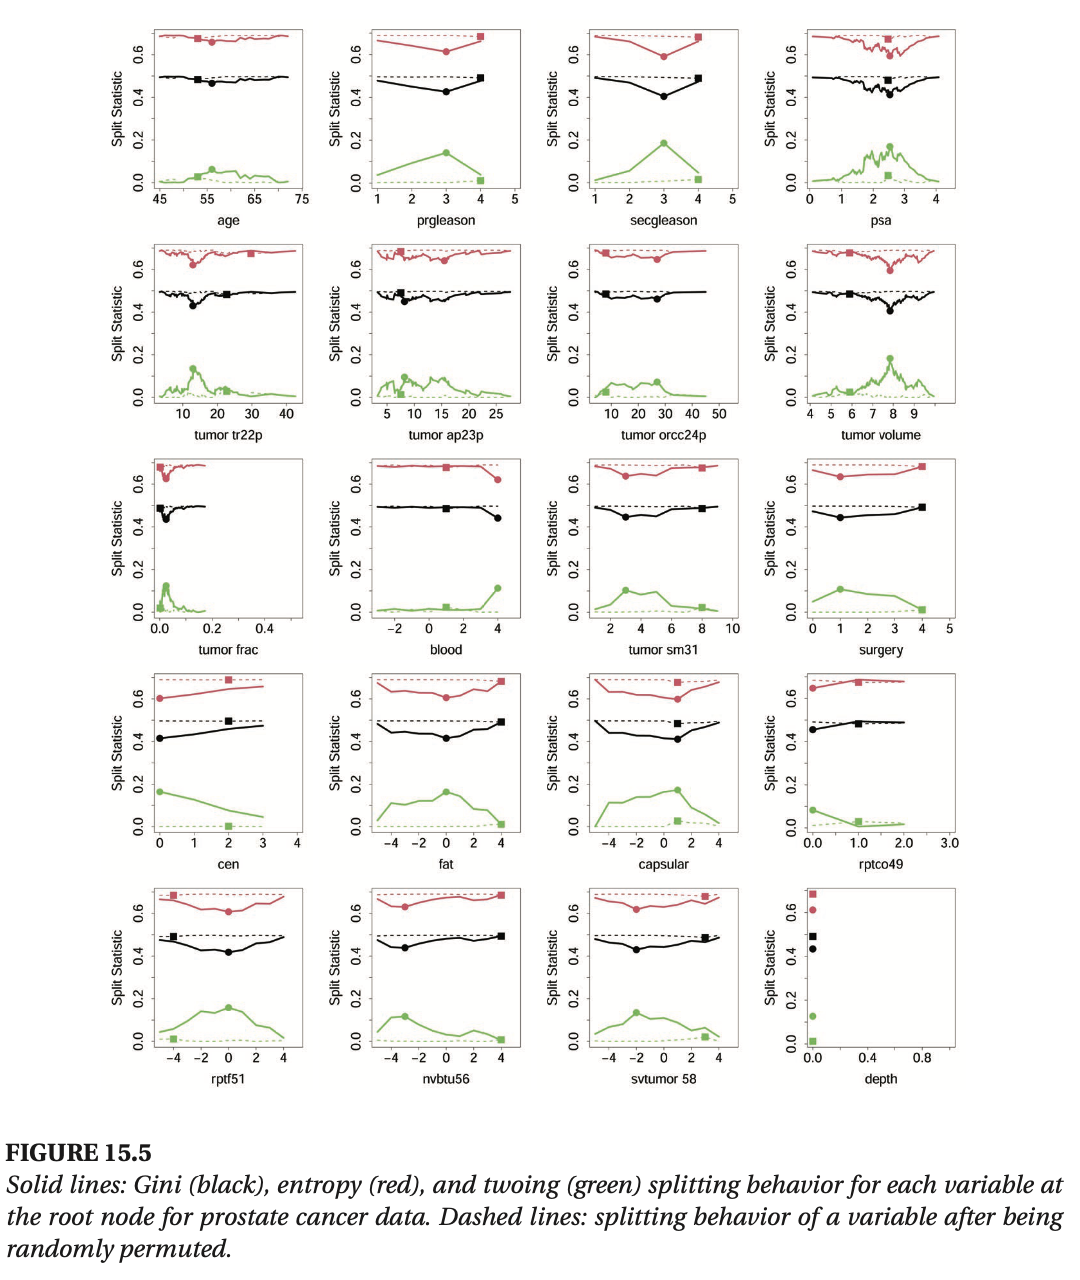

                 feature  best_threshold  max_gini_gain  perm_max_gain  \
0           worst radius       16.795000       0.325211       0.004063   
1             worst area      884.550000       0.323053       0.002909   
2        worst perimeter      105.950000       0.321984       0.004299   
3   worst concave points        0.142350       0.319228       0.006536   
4    mean concave points        0.051420       0.315368       0.003645   
5              mean area      696.250000       0.280812       0.004173   
6         mean perimeter       98.755000       0.275921       0.002894   
7            mean radius       15.045000       0.275105       0.004173   
8         mean concavity        0.093295       0.267140       0.004960   
9             area error       31.285000       0.251101       0.004063   
10       worst concavity        0.260500       0.235253       0.004227   
11       perimeter error        2.762000       0.180576       0.003908   

    gain_minus_perm  gain_ratio_vs_pe

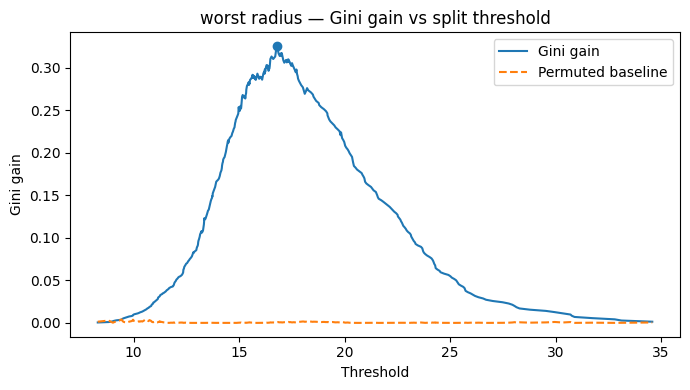

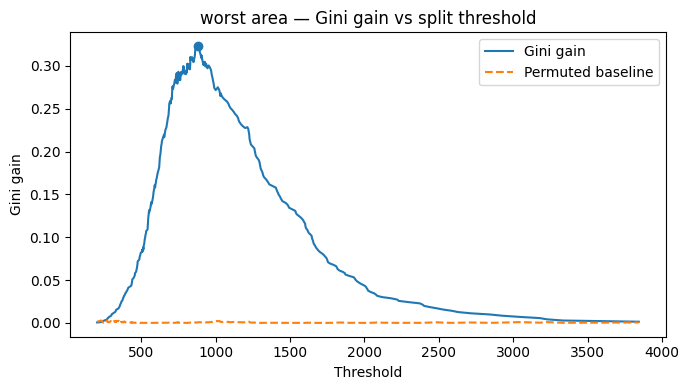

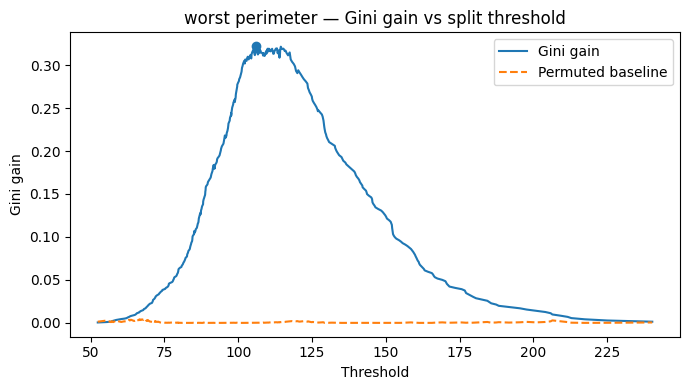

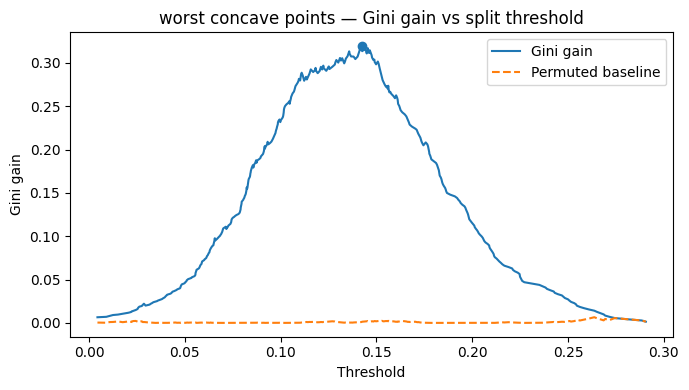

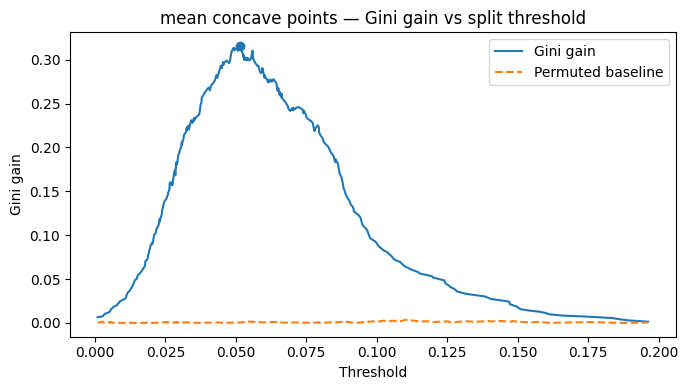

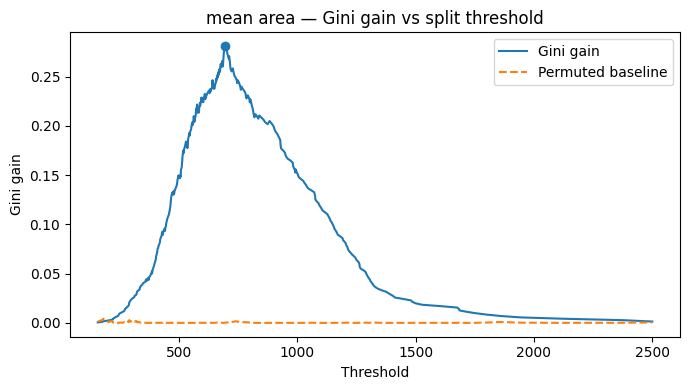

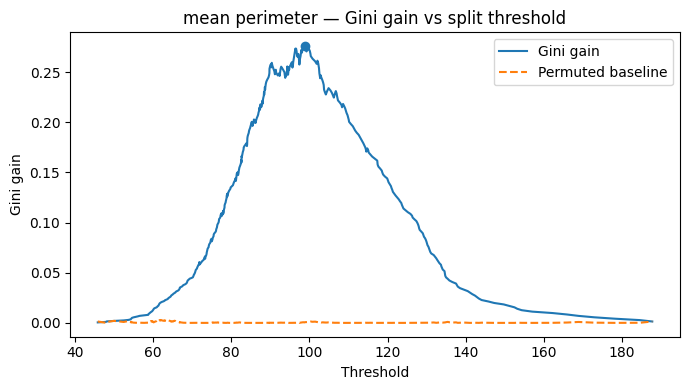

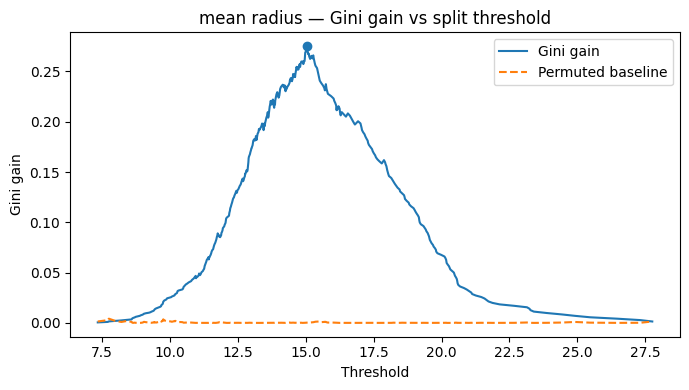

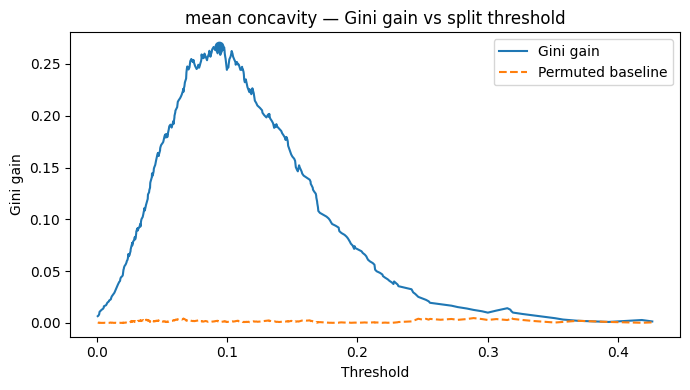

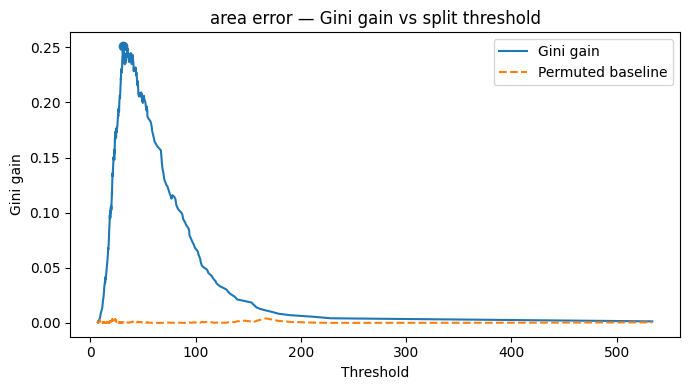

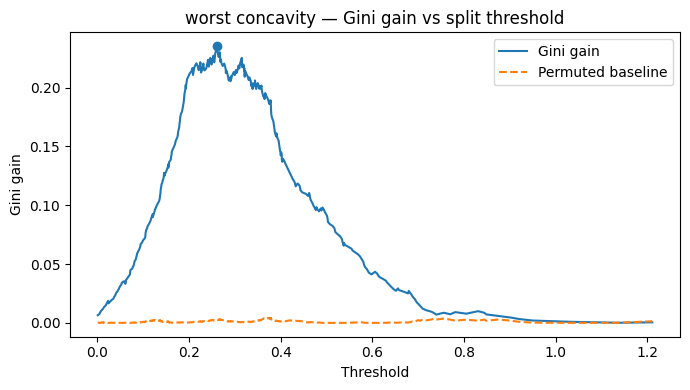

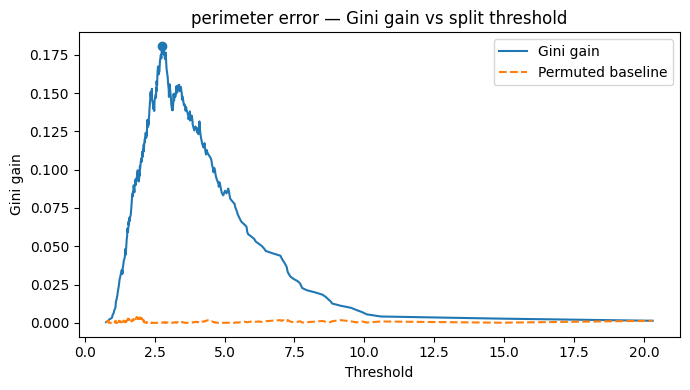

In [3]:
# Gini split statistic curves (Figure 15.5 style, one chart per feature)
# Dataset: Breast Cancer (Wisconsin Diagnostic)
# Requirements: numpy, pandas, scikit-learn, matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = (data.target == 0).astype(int)   # 1=malignant, 0=benign

n = len(y)
p_pos = y.mean()
gini_parent = 2 * p_pos * (1 - p_pos)

# Gini gain curve for one feature
def gini_gain_curve(x: np.ndarray, y: np.ndarray):
    order = np.argsort(x, kind="mergesort")
    xs = x[order]; ys = y[order]
    # indices where value changes -> split between those points
    uniq = np.flatnonzero(np.diff(xs)) + 1
    if len(uniq) == 0:
        return np.array([]), np.array([])
    thresholds = (xs[uniq - 1] + xs[uniq]) / 2.0

    cum_pos = np.cumsum(ys)
    gains = np.empty_like(thresholds, dtype=float)
    for j, k in enumerate(uniq):
        nL, nR = k, n - k
        posL = cum_pos[k - 1]
        posR = cum_pos[-1] - posL
        pL = posL / nL; pR = posR / nR
        gL = 2 * pL * (1 - pL); gR = 2 * pR * (1 - pR)
        weighted = (nL / n) * gL + (nR / n) * gR
        gains[j] = gini_parent - weighted
    return thresholds, gains

# Permuted baseline once
rng = np.random.default_rng(7)
y_perm = rng.permutation(y)

# Rank features by max gain
rows, curves, curves_perm = [], {}, {}
for feat in X.columns:
    xv = X[feat].to_numpy(dtype=float)
    th, g = gini_gain_curve(xv, y)
    thp, gp = gini_gain_curve(xv, y_perm)
    curves[feat] = (th, g)
    curves_perm[feat] = (thp, gp)
    best_gain = float(np.max(g)) if g.size else 0.0
    best_thr  = float(th[np.argmax(g)]) if g.size else np.nan
    best_perm = float(np.max(gp)) if gp.size else 0.0
    rows.append({
        "feature": feat,
        "best_threshold": best_thr,
        "max_gini_gain": best_gain,
        "perm_max_gain": best_perm,
        "gain_minus_perm": best_gain - best_perm,
        "gain_ratio_vs_perm": best_gain / (best_perm + 1e-12),
    })

summary = pd.DataFrame(rows).sort_values("max_gini_gain", ascending=False).reset_index(drop=True)
print(summary.head(12))  # top features

# Plot curves for top-K features (each in its own figure)
TOP_K = 12
for i in range(min(TOP_K, len(summary))):
    feat = summary.loc[i, "feature"]
    th, g = curves[feat]
    thp, gp = curves_perm[feat]

    plt.figure(figsize=(7, 4))
    if g.size:
        plt.plot(th, g, label="Gini gain")
        # mark best threshold
        b = int(np.argmax(g))
        plt.scatter([th[b]], [g[b]], marker="o")
    if gp.size:
        plt.plot(thp, gp, linestyle="--", label="Permuted baseline")
    plt.title(f"{feat} — Gini gain vs split threshold")
    plt.xlabel("Threshold"); plt.ylabel("Gini gain")
    plt.legend()
    plt.tight_layout()
    plt.show()

Yes useful variables comes out clearly. The max-Gini ranking shows large, sharp gains for worst radius/area/perimeter and (worst/mean) concave points/concavity (peak gains ≈0.31–0.33) while the permuted baselines are ~0 so strong univariate separation.
	•	Stable cutpoints. The gain–threshold curves have pronounced peaks at interpretable cutoffs (e.g., worst radius ≈16.8, worst concave points ≈0.14, worst perimeter ≈106). These are plausible screening thresholds for first-split rules.
	•	Consistency across related features. Multiple size measures (radius/area/perimeter) and shape irregularity measures (concavity/concave points) all rank top which is expected due to high correlation and shared signal.
	•	Lower-value features. Errors variants with small peaks (e.g., perimeter error) contribute less at the root also their curves are flatter and much closer to the permuted line.
	•	Caveats. This is a univariate, root-node screen: it ignores interactions and collinearity, so it can over-credit one of many correlated predictors. Use it to shortlist features, then confirm in multivariate models (trees, RF, logistic).

Hence the Gini-scan method successfully identifies the key breast-cancer predictors (tumor size and boundary irregularity) and provides sensible, data-driven threshold candidates.